# [Easy21](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf) solution

In [10]:
from enum import Enum
import logging
import random

import pandas as pd
import numpy as np

## Environment

In [11]:
# Set up environment for Easy21.
class Action(Enum):
    STICK = 0
    HIT = 1
   
def get_random_action():
    p = random.random()
    return Action.STICK if p < .5 else Action.HIT

class Color(Enum):
    RED = 0
    BLACK = 1
    
class Episode(object):
    def __init__(self, s):
        self.states = [s]
        self.actions = []
        self.rewards = []
   
    def add(self, s, a, r):
        self.states.append(s)
        self.actions.append(a)
        self.rewards.append(r)
        
    def __str__(self):
        return ("States: {}\nActions: {}\nRewards: {}".format(
            [s.player_sum for s in self.states], self.actions, self.rewards))
    
    def score(self):
        return self.rewards[-1]
        
class Card(object):   
    def __init__(self, color, value):
        self.color = color
        self.value = value
        
    def __str__(self):
        return "Card: {} {}".format(self.color, self.value)
    
class Reward(object):
    LOSS = -1
    DRAW = 0
    WIN = 1
    
class State(object):
    def __init__(self,
                 dealer_first_card=None,
                 player_sum=None,
                 is_terminal=False):
        self.dealer_first_card = dealer_first_card
        self.player_sum = player_sum
        self.is_terminal = is_terminal
        
    @property
    def key(self):
        """Returns a hashable key."""
        return (self.dealer_first_card.value, self.player_sum)
    
    def __str__(self):
        return ("State:\n\tDealer's first card: {}\n\t"
                "Player sum: {}\n\t"
                "Is terminal: {}\n".format(
            str(self.dealer_first_card),
            self.player_sum,
            self.is_terminal
        ))
    
def draw(v = None, c = None):
    """Returns a card from an infinite deck of cards.
    
    Each draw results in a value between 1 and 10 (uniformly distributed)
    with a color of red (p = 1/3) or black (p = 2/3).
    
    Args:
        v: A pre-determined value.
        c: A pre-determined color.
    """
    value = v or random.randint(1, 10)
    color = c or (Color.RED if random.random() < 1/3 else Color.BLACK)
    
    return Card(color=color, value=value)
   
class Round(object):
    BUST_LOWER_BOUND = 1
    BUST_UPPER_BOUND = 21
    
    # The dealer sticks on any sum of 17 or greater and hits otherwise.
    DEALER_STICK_VALUE = 17
    
    def __init__(self):
        pass
    
    @staticmethod
    def get_deck_sum(deck):
        """Returns the sum of a list of Card elements.
        
        Values are added (black) or subtracted (red).
        """
        s = sum([c.value for c in deck if c.color == Color.BLACK])
        s -= sum([c.value for c in deck if c.color == Color.RED])
        
        return s
    
    @staticmethod
    def is_busted(deck_sum):
        return (deck_sum > Round.BUST_UPPER_BOUND or \
           deck_sum < Round.BUST_LOWER_BOUND)
    
    @staticmethod
    def update_sum(cur_sum, card):  
        card_value = card.value if card.color == Color.BLACK \
                                else -1 * card.value
        return cur_sum + card_value
    
    def step(self, s, a):
        """Returns a sample of the next state s' and reward r.
    
        Args:
            s: A state.
            a: An action.
        """
        # If the player hits...
        if a == Action.HIT:
            # She draws another card from the deck.
            card = draw()
            
            logging.debug("Player hits and draws {}".format(card))
                
            # The value of the player's cards are added (black) or
            # subtracted (red cards).
            player_sum = Round.update_sum(s.player_sum, card)
            
            logging.debug("Player sum: {}".format(player_sum))
                    
            ns = State(
                    dealer_first_card=s.dealer_first_card,
                    player_sum=player_sum,
                    is_terminal=False)
            
            if Round.is_busted(player_sum):
                logging.debug("Busted! Womp womp.")
                ns.is_terminal = True
                return (ns, Reward.LOSS)
            
            else:
                logging.debug("Next state: {}".format(ns))
                    
                return (ns, 0) # Game is still going, no reward.
            
        # If the player sticks:
        else:
            # She receives no further cards.
            player_sum = s.player_sum
            
            logging.debug("Player is sticking with sum {}".format(
                    player_sum))
                
            dealer_sum = s.dealer_first_card.value
            
            # The dealer starts taking turns.
            while (dealer_sum < Round.DEALER_STICK_VALUE and \
                  not(Round.is_busted(dealer_sum))):
                    
                # Dealer hits.
                card = draw()
                
                dealer_sum = Round.update_sum(dealer_sum, card)
                logging.debug("\tDealer draws {}, sum: {}".format(
                    card, dealer_sum))
            
            if Round.is_busted(dealer_sum):
                logging.debug("Dealer busted!")
            else:
                logging.debug("Dealer is sticking with sum {}".format(
                    dealer_sum))
            
            ns = State(is_terminal=True)

            if Round.is_busted(dealer_sum):
                r = Reward.WIN
            # This probably will not be triggered.
            elif Round.is_busted(player_sum):
                r = Reward.LOSS
            elif player_sum == dealer_sum:
                r = Reward.DRAW
            else:
                r = Reward.WIN if player_sum > dealer_sum \
                    else Reward.LOSS
                
            logging.debug("Reward: {}".format(r))
            
            return (ns, r)

Average score: -0.2738 (-2738/10000)
	Wins: 3387
	Draws: 488
	Losses: 6125


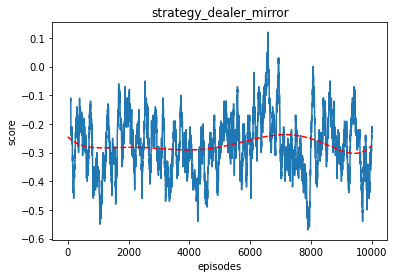

In [12]:
# Add baselines and wrappers to play the game.
def strategy_always_hit(s):
    return Action.HIT

def strategy_always_stick(s):
    return Action.STICK

def strategy_dealer_mirror(s):
    """This strategy also sticks at 17+."""
    if s.player_sum >= 17:
        return Action.STICK
    return Action.HIT

def run_episode(strategy, show_debug=False, eval_episode_fn=None):
    if show_debug:
        logging.getLogger().setLevel(logging.DEBUG)
    else:
        logging.getLogger().setLevel(logging.INFO)
        
    # Initialize.
    # Player starts with a black card.
    player_first_card = draw(c=Color.BLACK)
    player_sum = player_first_card.value
    logging.debug("Player first card: {}".format(player_first_card))

    # Dealer starts with a black card.
    dealer_first_card = draw(c=Color.BLACK)
    logging.debug("Dealer first card: {}".format(dealer_first_card))

    game = Round()
    
    s = State(dealer_first_card=dealer_first_card,
          player_sum=player_sum,
          is_terminal=False)
    episode = Episode(s)
    
    while (not s.is_terminal):
        a = strategy(s)
        ns, r = game.step(s, a)
        episode.add(ns, a, r)
        
        is_terminal = ns.is_terminal
        s = ns
       
    if eval_episode_fn:
        eval_episode_fn(episode)
        
    return episode

def run_episodes(n, strategy, show_debug=False, eval_episode_fn=None):
    episodes = []
    for i in range(n):
        e = run_episode(strategy, show_debug=show_debug, eval_episode_fn=eval_episode_fn)
        episodes.append(e)

    rs = [e.score() for e in episodes]
    print("Average score: {} ({}/{})".format(sum(rs)/len(rs), sum(rs), len(rs)))
    print("\tWins: {}".format(sum([1 for r in rs if r == 1])))
    print("\tDraws: {}".format(sum([1 for r in rs if r == 0])))
    print("\tLosses: {}".format(sum([1 for r in rs if r == -1])))
    
    # Plot graph over episodes.
    rolling_n = round(n/100)
    ax = pd.Series(rs).rolling(rolling_n).mean()[rolling_n - 1:].plot(
        title=strategy.__name__)
    ax.set_xlabel("episodes")
    ax.set_ylabel("score")
    
    # Add a trendline.
    x = [x for x in range(len(rs))]
    z = np.polyfit(x, rs, 6)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--")
    
    return episodes


# e = run_episode(strategy_dealer_mirror, show_debug=False)
# print(e)

episodes = run_episodes(10000, strategy_dealer_mirror, show_debug=False)

## Monte-Carlo control

In [39]:
# Monte-Carlo policy evaluation Q = q_\pi

class MonteCarloControl(object):
    N_INIT = 100
    
    def __init__(self):
        self.counters = {}
        self.q_values = {}
        
        self.returns = {}
        self.n = 1
    
    def get_epsilon(self, s):
        if s.key not in self.counters:
            self.counters[s.key] = [0., 0.]
            
        logging.debug(self.counters[s.key])
        n_s = sum(self.counters[s.key])
        return MonteCarloControl.N_INIT / (
            MonteCarloControl.N_INIT + n_s)
    
    def evaluate_episode(self, e):
        """Monte-Carlo policy evaluation."""
        # is.gd/kZpF7y
        g_t = e.score()
        
        # Every time-step t that state s is visited in an epsiode:
        for i in range(len(e.states)):
            s = e.states[i]
            if s.is_terminal:
                continue
                
            a = e.actions[i]
            # N(S_t, A_t) <- N(S_t, A_t) + 1
            if s.key not in self.counters:
                self.counters[s.key] = [0, 0]
            self.counters[s.key][a.value] += 1
                
            # Initialize the value function to 0.
            if s.key not in self.q_values:
                self.q_values[s.key] = [0., 0.]
                
            # Increment total return:
            # Q(s) <- Q(s) + /frac{1}{N(S_t, A_t)}(G_t - Q(S_t, A_t))
            prev_q = self.q_values[s.key][a.value]
            self.q_values[s.key][a.value] += (
                1 / self.counters[s.key][a.value]) * (g_t - prev_q)
       
        # Improve policy based on new action-value function.
    
    def get_greedy_action(self, s):
        if s not in self.q_values:
            logging.debug("State {} not in q_values!".format(s))
            return get_random_action()
        
        return max(self.q_values[s])
    
    def glie_mc_control(self, s):
        """Returns the action to take."""
        epsilon = self.get_epsilon(s)
        p = random.random()
        # With probability epsilon, choose an action at random.
        if p < epsilon:
            return get_random_action()
        
        # With probability 1 - epsilon, choose the greedy action.
        else:
            return self.get_greedy_action(s)

Average score: -0.10647 (-10647/100000)
	Wins: 44423
	Draws: 507
	Losses: 55070


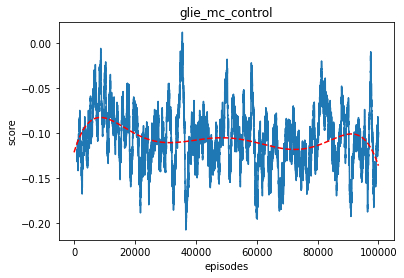

In [41]:
mc = MonteCarloControl()
episodes = run_episodes(100000, mc.glie_mc_control, show_debug=False, eval_episode_fn=mc.evaluate_episode)

In [ ]:
# Initialize the value function to 0
# Use a time-varying scalar step-size of \alpha_t = 1/N(s_t, a_t)
# And an \epsilon-greedy exploration strategy with 
# \epsilon_t = N_0 / (N_0 + N(s_t)), where N_0 = 100

Average score: -1.0 (-5000/5000)
	Wins: 0
	Draws: 0
	Losses: 5000


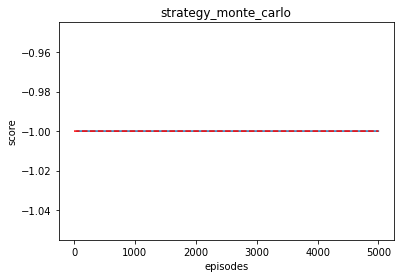

In [72]:
def strategy_monte_carlo(s):
    return Action.HIT

episodes = run_episodes(5000, strategy_monte_carlo, show_debug=False)

## Tests

In [3]:
# Verify draw distributions.
numbers = [0] * 10
colors = [0] * 2

for i in range(100000):
    card = draw()
    # Expected to be uniform.
    numbers[card.value - 1] += 1
    
    # Expected to be 1/3, 2/3.
    colors[card.color.value] += 1
    
print(numbers)
print(colors)

[10063, 9849, 10006, 9918, 10001, 10018, 10037, 10077, 10020, 10011]
[33536, 66464]


In [4]:
# Verify Round.get_deck_sum() 
cards = [Card(Color.BLACK, 1), Card(Color.RED, 4), Card(Color.BLACK, 3)]
# Expected 0 (1 + 3 - 4)
print(Round.get_deck_sum(cards))

# Verify is_busted().
cards = [Card(Color.BLACK, 23), Card(Color.RED, 4), Card(Color.BLACK, 3)]
s = sum([c.value for c in cards])
print(Round.is_busted(s))

0
True


Average score: -0.2768


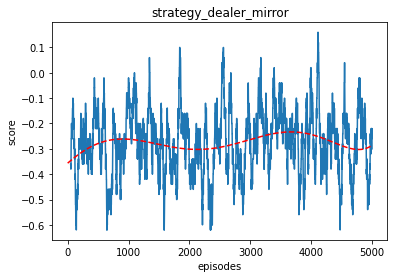